# 📊 Data Preparation

This notebook prepares the data for training the deep learning model. At a highlevel it performs the following tasks:
1. Stratified k-fold spliting the dataset
2. Tokenize 
3. Create hugging face Dataset

## ⚙️ Setup 

### 📚 Importing Libraries

Importing from packages

In [1]:
import os
import pandas as pd
from tqdm import tqdm
from pprint import pprint
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import StratifiedKFold
from transformers import AutoTokenizer
from tokenizers import AddedToken

/media/ishfar/New Volume/Studies/Projects/Kaggle-Automated-Essay-Scoring/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.chdir("../")

Importing user defined packages

In [3]:
from lib.utils.utils import seed_everything
from lib.config import Config
from lib.paths import Paths
from lib.data import get_data_loaders

### 🌱 Setting Random Seeds

In [4]:
seed_everything(Config.RANDOM_SEED)

### 💽 Loading Data

In [5]:
train_df = pd.read_csv(Paths.TRAIN_CSV_PATH)
test_df = pd.read_csv(Paths.TEST_CSV_PATH)

train_df.shape, test_df.shape

((17307, 5), (3, 4))

In [6]:
train_df["score"] = train_df["score"] - 1

## ✂️ Train-Validation Splitting

Use `StratifiedGroupKFold` to split `train_df` into `Config.N_FOLDS`.

Sources
1. [MOTH's Notebook](https://www.kaggle.com/code/alejopaullier/aes-2-multi-class-classification-train?scriptVersionId=170290107&cellId=12)

In [7]:
skf = StratifiedKFold(n_splits=Config.N_FOLDS)

Seperate feature `X` and labels `y`.

In [8]:
X, y = train_df["full_text"], train_df["score"]

Assign fold number to dataframe `train_df`

In [9]:
train_df["fold"] = -1

for i, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    train_df.loc[valid_idx, "fold"] = i

Distribution of data across `Config.N_FOLDS`.

In [10]:
train_df["fold"].value_counts()

fold
0    3462
1    3462
2    3461
3    3461
4    3461
Name: count, dtype: int64

## 🪙 Tokenizer

Sources:
1. [MOTH's Notebook](https://www.kaggle.com/code/alejopaullier/aes-2-multi-class-classification-train?scriptVersionId=170290107&cellId=14)

In [11]:
%env TOKENIZERS_PARALLELISM=true

env: TOKENIZERS_PARALLELISM=true


In [12]:
tokenizer = AutoTokenizer.from_pretrained(Config.MODEL)
tokenizer.add_tokens([AddedToken("\n", normalized=False)])
tokenizer.save_pretrained(Paths.TOKENIZER_PATH)

/media/ishfar/New Volume/Studies/Projects/Kaggle-Automated-Essay-Scoring/venv/lib/python3.11/site-packages/transformers/convert_slow_tokenizer.py:550: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


('output/microsoft/deberta-v3-base/tokenizer_v1/tokenizer_config.json',
 'output/microsoft/deberta-v3-base/tokenizer_v1/special_tokens_map.json',
 'output/microsoft/deberta-v3-base/tokenizer_v1/spm.model',
 'output/microsoft/deberta-v3-base/tokenizer_v1/added_tokens.json',
 'output/microsoft/deberta-v3-base/tokenizer_v1/tokenizer.json')

In [13]:
print(tokenizer)

DebertaV2TokenizerFast(name_or_path='microsoft/deberta-v3-base', vocab_size=128000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	128000: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128001: AddedToken("
", rstrip=False, lstrip=F

## 🗃️ Torch Dataset

Sources
1. [MOTH's Notebook](https://www.kaggle.com/code/alejopaullier/aes-2-multi-class-classification-train?scriptVersionId=170290107&cellId=16)

In [14]:
lengths = [
    len(tokenizer(text, add_special_tokens=False)["input_ids"])
    for text in tqdm(train_df["full_text"].fillna(""), total=len(train_df))
]

  0%|          | 0/17307 [00:00<?, ?it/s]

100%|██████████| 17307/17307 [00:09<00:00, 1872.45it/s]


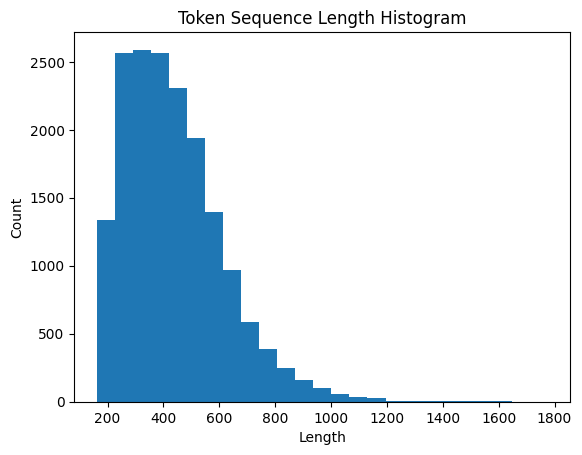

In [15]:
_ = plt.hist(lengths, bins=25)
plt.title("Token Sequence Length Histogram")
plt.xlabel("Length")
plt.ylabel("Count")
plt.show()

In [16]:
if Config.DEBUG:
    train_fold = train_df[train_df["fold"] != 0].reset_index(drop=True)
    valid_fold = train_df[train_df["fold"] == 0].reset_index(drop=True)

    train_loader, valid_loader = get_data_loaders(train_fold, valid_fold, tokenizer)

    # === Let's check one sample ===
    for sample in train_loader:
        pprint(f"Encoding keys: {sample.keys()} \n")
        pprint(sample)
        break

Saving data loaders to disk.

In [17]:
if not os.path.exists(Paths.DATA_LOADER_PATH):
    os.makedirs(Paths.DATA_LOADER_PATH)

for fold in train_df.fold.unique():
    train_fold = train_df[train_df["fold"] != fold].reset_index(drop=True)
    valid_fold = train_df[train_df["fold"] == fold].reset_index(drop=True)

    train_loader, valid_loader = get_data_loaders(train_fold, valid_fold, tokenizer)

    train_dataloader_path = os.path.join(Paths.DATA_LOADER_PATH, f"train_{fold}.pth")
    torch.save(train_loader, train_dataloader_path)
    print(f"Saved {train_dataloader_path}")

    valid_dataloader_path = os.path.join(Paths.DATA_LOADER_PATH, f"valid_{fold}.pth")
    torch.save(valid_loader, valid_dataloader_path)
    print(f"Saved {valid_dataloader_path}")

    valid_csv_path = os.path.join(Paths.DATA_LOADER_PATH, f"valid_{fold}.csv")
    valid_fold.to_csv(valid_csv_path, index=False)
    print(f"Saved {valid_csv_path}")

Saved data/dataloader_v1/train_0.pth
Saved data/dataloader_v1/valid_0.pth
Saved data/dataloader_v1/valid_0.csv
Saved data/dataloader_v1/train_1.pth
Saved data/dataloader_v1/valid_1.pth
Saved data/dataloader_v1/valid_1.csv
Saved data/dataloader_v1/train_2.pth
Saved data/dataloader_v1/valid_2.pth
Saved data/dataloader_v1/valid_2.csv
Saved data/dataloader_v1/train_3.pth
Saved data/dataloader_v1/valid_3.pth
Saved data/dataloader_v1/valid_3.csv
Saved data/dataloader_v1/train_4.pth
Saved data/dataloader_v1/valid_4.pth
Saved data/dataloader_v1/valid_4.csv
